The most hard part: getting the right text representation? No, it was the fact that my WiFi is gone and I have train that thing locally and setup the whole environment locally 😿

The embedding layer from Pytorch takes as input tokens and map them to vectors, those vectors are initialized to random values then updated later by backprob.

One more thing: nn.embedding is very similar to nn.linear, the difference between Embedding and Linear: Linear expects vectors (e.g. one-hot representation of the words), Embedding expects tokens (e.g. words index)



### Import libs

In [2]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

from tqdm import trange

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(42)

In [6]:
data = pd.read_csv("train_data.csv")
data.head()

,text,label
0,ابغى شوف الاكل يلي موجود,X X X X X
1,فيني اطلب وجبة البيج تيستي,X X ItemName ItemName ItemName
2,فيني تابع الاوردر بليز,X X X X
3,شنو هاي,X X
4,عايز اشوف المنيو,X X X


## Getting the indices of words

In addition to words read from the dataset, I added an UNK token to represent any word that is not present in the vocabulary, and a PAD token that is used as a filler token at the end of a sentence when one batch has sentences of unequal lengths.

In [7]:
# loading vocab (we require this to map words to their indices)
words=["PAD","UNK"]
for i in data["text"]:
    words+=i.split()

print("length of words:",len(words))


words_map = {}
i=0
for  l in words:
    if l not in words_map.keys():
        words_map[l] = i
        i+=1
print("length of words_map or number of unique words:",len(words_map))

print(words_map["عايزة"])
print(words_map["احط"])
print(words_map["عنوان"])
print(words_map["بيتي"])
print(max(words_map.values()))

length of words: 18058
length of words_map or number of unique words: 2264
27
381
156
157
2263


In [8]:
# getting the indices for UNKnown words and PADding symbols
unk_ind = words_map["PAD"]
pad_ind = words_map["UNK"]
unk_ind,pad_ind

(0, 1)

### Getting the indices for labels

In [9]:
labels = []
for i in data["label"]:
    labels+=i.split()
print(len(labels))

labels_map = {}
for i, l in enumerate(labels):
    if l not in labels_map.keys():
        labels_map[l] = i
    
print(len(labels_map))
print(labels_map)

18056
13
{'X': 0, 'ItemName': 7, 'MenuName': 42, 'OrderNumber': 64, 'itemnumber': 102, 'Language': 110, 'ItemSize': 114, 'phone': 145, 'PredefinedMealName': 269, 'Include': 282, 'Topping_Include': 283, 'Exclude': 340, 'Topping_Exclude': 341}


### Forming the new dataset using the indices

In [10]:
train_sentences = []        
train_labels = []
longest_senetence = -1
for sentence in data["text"]:
    #replace each token by its index
    s = [words_map[token] for token in sentence.split(' ')]
    if len(s)>longest_senetence:
        longest_senetence=len(s)
    train_sentences.append(s)

print("longest_senetence have",longest_senetence,"words")
    
for sentence in data["label"]:
    #replace each label by its index
    l = [labels_map[label] for label in sentence.split(' ')]
    train_labels.append(l)  

longest_senetence have 16 words


In [11]:
print(words_map["عايزة"])
print(words_map["احط"])
print(words_map["عنوان"])
print(words_map["بيتي"])
print(data["text"].head(1))
train_sentences[0]

27
381
156
157
0    ابغى شوف الاكل يلي موجود
Name: text, dtype: object


[2, 3, 4, 5, 6]

In [12]:
print(labels_map["X"])
print(data["label"].head(1))
train_labels[0]

0
0    X X X X X
Name: label, dtype: object


[0, 0, 0, 0, 0]

## Doing itall for test data

In [13]:
def get_data(path,words_map,labels_map):
    data = pd.read_csv(path)
    print("data shape",data.shape)
    
    sentences = []        
    labels = []
    longest_senetence = -1
    for sentence in data["text"]:
        #replace each token by its index
        s = [words_map[token] if token in words_map 
            else words_map['UNK'] for token in sentence.split(' ')]
        if len(s)>longest_senetence:
            longest_senetence=len(s)
        sentences.append(s)

    print("longest_senetence have",longest_senetence,"words")
        
    for sentence in data["label"]:
        #replace each label by its index
        l = [labels_map[label] for label in sentence.split(' ')]
        labels.append(l)  
        
    
    data={}
    
    data["size"]=len(sentences)
    data["sentences"]=sentences
    data["labels"]=labels

    return data

In [14]:
test_data=get_data("test_data.csv",words_map,labels_map)

data shape (1006, 2)
longest_senetence have 15 words


### Preparing a Batch

When sampling a batch of sentences, not all the sentences usually have the same length, I already calculated the length of the longest sentence in the cells above.

In [15]:
#training parsams
batch_size = 32
device = "cpu"#"cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [16]:
#packing the training data
train_data={}
train_data["size"]=len(train_sentences)
train_data["sentences"]=train_sentences
train_data["labels"]=train_labels
print(train_data["size"])

4024


In [17]:
def data_iterator(data, shuffle=False):
        # make a list that decides the order in which we go over the data- this avoids explicit shuffling of data
        order = list(range(data['size']))
        if shuffle:
            random.seed(42)
            random.shuffle(order)

        # one pass over data
        for i in range((data['size']+1)//batch_size):
            # fetch sentences and tags
            batch_sentences = [data['sentences'][idx] for idx in order[i*batch_size:(i+1)*batch_size]]
            batch_tags = [data['labels'][idx] for idx in order[i*batch_size:(i+1)*batch_size]]

            # compute length of longest sentence in batch
            batch_max_len = max([len(s) for s in batch_sentences])

            # prepare a numpy array with the data, initialising the data with pad_ind and all labels with -1
            # initialising labels to -1 differentiates tokens with tags from PADding tokens
            batch_data = pad_ind*np.ones((len(batch_sentences), batch_max_len))
            batch_labels = -1*np.ones((len(batch_sentences), batch_max_len))

            # copy the data to the numpy array
            for j in range(len(batch_sentences)):
                cur_len = len(batch_sentences[j])
                batch_data[j][:cur_len] = batch_sentences[j]
                batch_labels[j][:cur_len] = batch_tags[j]

            # since all data are indices, we convert them to torch LongTensors
            batch_data, batch_labels = torch.LongTensor(batch_data), torch.LongTensor(batch_labels)

            # shift tensors to GPU if available
            batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)

            # convert them to Variables to record operations in the computational graph
            batch_data, batch_labels = Variable(batch_data), Variable(batch_labels)
    
            yield batch_data, batch_labels

In [18]:
train_iterator = data_iterator(train_data, shuffle=True)
next(train_iterator)

(tensor([[ 253, 1489,  231,    1,    1,    1,    1],
         [  17,  145,  127,  609,  671,    1,    1],
         [  17,  325,  156,  914,    1,    1,    1],
         [ 253, 1387,   46,  141,    1,    1,    1],
         [ 142,  143,  777,    5,  214,    1,    1],
         [ 132,  760,   58,  126,  127,    1,    1],
         [ 988,    1,    1,    1,    1,    1,    1],
         [ 120,  121,   17,  117,   83,  685,    1],
         [  77,   78,   17,  117,  423,    1,    1],
         [1038,  544,   13,    1,    1,    1,    1],
         [ 348,    1,    1,    1,    1,    1,    1],
         [ 199,  161, 1200, 1851, 1852, 1853, 1727],
         [  17,  265,  518,   49,    1,    1,    1],
         [  27,   23,   24,   80,   77,   78,    1],
         [  17,  472,  120,  121,    1,    1,    1],
         [  50,  131,  739,  610,    1,    1,    1],
         [  17,   89,  865,  994,  906,    1,    1],
         [  27,  103,  104,  675,    1,    1,    1],
         [  50,  181,   13,  178,  729,   68, 

Note: all the "1" are padding and -1 is the label for the padding token

In [19]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #maps each token to an embedding_dim vector
        #PyTorch created a lookup table called embedding. 
        #This table has 2266 rows and 1000 columns.
        #2266 is the number of unique words + "pad" and "unk" that we have in that dataset
        self.embedding = nn.Embedding(2266, 1000)
        #the LSTM takens embedded sentence
        #the fiirst 1000 is the input size and also the embedding_dim
        #the second 1000 is the hidden_size
        self.lstm = nn.LSTM(1000, 1000)
        #fc layer transforms the output to give the final output layer
        #the first 1000 is the input size and also the hidden size of the lstm
        #the 13 is the number_of_tags
        self.fc = nn.Linear(1000, 13)
    def forward(self, s):
        #                                -> batch_size x seq_len
        # apply the embedding layer that maps each token to its embedding
        # dim: batch_size x seq_len x embedding_dim
        s = self.embedding(s)

        # run the LSTM along the sentences of length seq_len
        # dim: batch_size x seq_len x lstm_hidden_dim
        s, _ = self.lstm(s)

        # make the Variable contiguous in memory (a PyTorch artefact)
        s = s.contiguous()

        # reshape the Variable so that each row contains one token
        # dim: batch_size*seq_len x lstm_hidden_dim
        s = s.view(-1, s.shape[2])

        # apply the fully connected layer and obtain the output (before softmax) for each token
        s = self.fc(s)                   # dim: batch_size*seq_len x num_tags

        # apply log softmax on each token's output (this is recommended over applying softmax
        # since it is numerically more stable)
        return F.log_softmax(s, dim=1)   # dim: batch_size*seq_len x num_tags



https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html

In [20]:
def train(model, optimizer, loss_fn, data_iterator, num_steps):
    # set model to training mode
    model.train()

    # summary for current training loop and a running average object for loss
    no_steps=0
    total_loss=0


    # Use tqdm for progress bar
    t = trange(num_steps)
    for _ in t:
        # fetch the next training batch
        train_batch, labels_batch = next(data_iterator)

        # compute model output and loss
        #print(train_batch.size())
        output_batch = model.forward(train_batch)
        #print(output_batch.size())
        loss = loss_fn(output_batch, labels_batch)

        # clear previous gradients, compute gradients of all variables wrt loss
        optimizer.zero_grad()
        loss.backward()

        # performs updates using calculated gradients
        optimizer.step()

        # update the average loss
        total_loss+=loss.item()
        no_steps+=1
        t.set_postfix(loss='{:05.3f}'.format(total_loss/num_steps))

In [36]:
def evaluate(model, loss_fn, data_iterator, metric, num_steps):

    # set model to evaluation mode
    model.eval()

    # summary for current eval loop
    summ = []

    # compute metric over the dataset
    for _ in range(num_steps):
        # fetch the next evaluation batch
        data_batch, labels_batch = next(data_iterator)
        
        # compute model output
        output_batch = model(data_batch)
        loss = loss_fn(output_batch, labels_batch)

        # extract data from torch Variable, move to cpu, convert to numpy arrays
        output_batch = output_batch.data.cpu().numpy()
        labels_batch = labels_batch.data.cpu().numpy()

        # compute all metric on this batch
        summary_batch = {'accuracy': metric(output_batch, labels_batch)}
        summary_batch['loss'] = loss.item()
        summ.append(summary_batch)

    # compute mean of all metric in summary
    metric_mean = {metric:np.mean([x[metric] for x in summ]) for metric in summ[0]} 
    metric_string = " ; ".join("{}: {:05.3f}".format(k, v) for k, v in metric_mean.items())
    accuracy_for_all_epochs.append(metric_mean['accuracy'])
    losses_for_all_epochs.append(metric_mean['loss'])
    print("- Eval metric : " + metric_string)
    return metric_mean

In [34]:
def train_and_evaluate(model, train_data, val_data, optimizer, loss_fn, metrics):

    best_val_acc = 0.0

    for epoch in range(num_epochs):
        # Run one epoch
        print("Epoch {}/{}".format(epoch + 1, num_epochs))
        num_steps = (val_size ) // batch_size
        val_data_iterator = data_iterator(
            val_data, shuffle=False)
        val_metrics = evaluate(
            model, loss_fn, val_data_iterator, metrics, num_steps)

        val_acc = val_metrics['accuracy']
        is_best = val_acc > best_val_acc


        # compute number of batches in one epoch (one full pass over the training set)
        num_steps = (train_size) // batch_size
        train_data_iterator = data_iterator(
            train_data, shuffle=True)
        #def train(model, optimizer, loss_fn, data_iterator, num_steps):

        train(model, optimizer, loss_fn, train_data_iterator, num_steps)

        # Evaluate for one epoch on validation set
        
        
        # If best_eval, best_save_path
        if is_best:
            print("- Found new best accuracy")
            best_val_acc = val_acc

            

In [27]:
def accuracy(outputs, labels):

    # reshape labels to give a flat vector of length batch_size*seq_len
    labels = labels.ravel()

    # since PADding tokens have label -1, we can generate a mask to exclude the loss from those terms
    mask = (labels >= 0)

    # np.argmax gives us the class predicted for each token by the model
    outputs = np.argmax(outputs, axis=1)

    # compare outputs with labels and divide by number of tokens (excluding PADding tokens)
    return np.sum(outputs == labels)/float(np.sum(mask))

In [28]:
def loss_fn(outputs, labels):

    # reshape labels to give a flat vector of length batch_size*seq_len
    labels = labels.view(-1)

    # since PADding tokens have label -1, we can generate a mask to exclude the loss from those terms
    mask = (labels >= 0).float()

    # indexing with negative values is not supported. Since PADded tokens have label -1, we convert them to a positive
    # number. This does not affect training, since we ignore the PADded tokens with the mask.
    labels = labels % outputs.shape[1]

    num_tokens = int(torch.sum(mask))

    # compute cross entropy loss for all tokens (except PADding tokens), by multiplying with mask.
    return -torch.sum(outputs[range(outputs.shape[0]), labels]*mask)/num_tokens


In [51]:
model = Net()
loss_function = loss_fn
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs=100
accuracy_for_all_epochs=[]
losses_for_all_epochs=[]
train_size=len(train_sentences)
val_size=len(test_data["sentences"])

In [ ]:
train_and_evaluate(model, train_data, test_data, optimizer, loss_function, accuracy)

In [48]:
torch.save(model, 'model.pth')

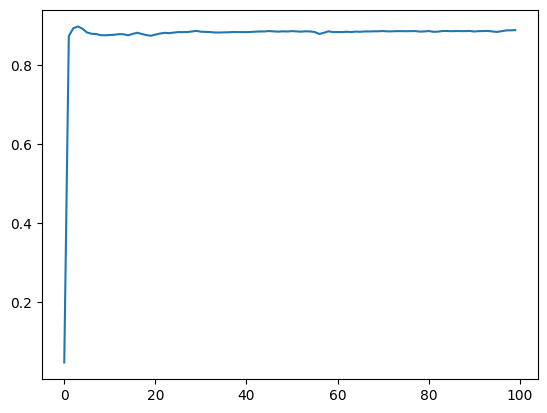

In [49]:
def get_accuracy_report():
    pass
plt.plot(range(num_epochs),accuracy_for_all_epochs)

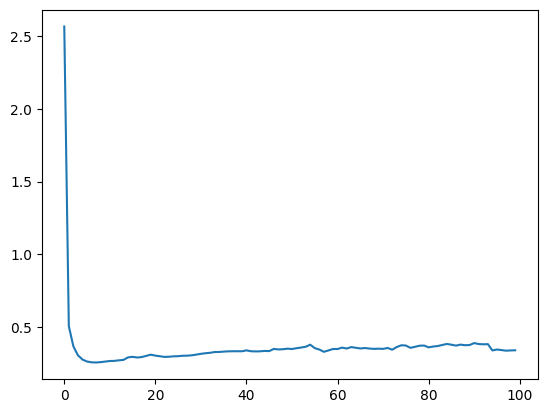

In [50]:
plt.plot(range(num_epochs),losses_for_all_epochs)